# TarDiff - génération ciblée par influence 

Ce notebook est mon implémentation personnelle de l’article [TarDiff: Target-Oriented Diffusion Guidance for Synthetic Electronic Health Record Time Series Generation](https://arxiv.org/abs/2504.17613) de Bowen Deng et al., 2023 dans le cadre de mon cours de simulation et modèles génératifs enseigné par Sylvain Le Corff. 

Le but est de maitriser en profondeur l'article en l'implémentant sur un jeu de données simple (2D) avant de l'appliquer sur un jeu de données réel (ECG) et de challenger la performance / pertinence des différents choix d'implémentations et d'hyperparamètres.  

## 1. Introduction

### Contexte et objectif

Les modèles de diffusion permettent de générer des séries temporelles médicales synthétiques (EHR), utiles pour pallier la rareté des données et les contraintes de confidentialité.  
Cependant, la plupart des approches existantes optimisent uniquement le **réalisme** des données générées, sans se soucier de leur **utilité pour les tâches cliniques downstream** (ex. prédiction de mortalité ou d’admission en réanimation).

Résultat : les données synthétiques reproduisent surtout des trajectoires fréquentes, et apportent peu d’information pour les cas rares mais cliniquement critiques.

Or, en pratique clinique, les données sont fortement **déséquilibrées** : la majorité des patients ne présentent pas l’événement d’intérêt (ex. décès, admission en réanimation, complications sévères...). C'est une bonne nouvelle :), mais les modèles génératifs tendent alors à sur-représenter des trajectoires fréquentes. 

Donc il est crucial de générer des données synthétiques qui soient non seulement réalistes, mais aussi **utiles** pour les tâches cliniques spécifiques.

### Idée clé de TarDiff

**TarDiff** (Target-Oriented Diffusion) propose de guider la génération de données synthétiques en fonction de leur impact sur une tâche cible.

Pour cela :
- on mesure, via des **fonctions d’influence**, l’effet qu’un échantillon synthétique aurait sur les performances d’un modèle prédictif donné,
- ces scores d’influence sont utilisés comme signal de guidage dans le processus inverse de diffusion.

La génération est ainsi orientée vers des échantillons qui sont :
- plausibles d’un point de vue médical,
- explicitement bénéfiques pour la tâche clinique considérée.

### Plan du notebook

1. Introduction
2. Présentation formelle de la méthode TarDiff
3. Implémentation de TarDiff sur un jeu de données 2D simple
4. Analyse de la méthode sur un jeu simple biaisé
5. Application à des données ECG réelles 
6. Discussion et perspectives

## 2. Présentation formelle de la méthode TarDiff

L'idée centrale de TarDiff est de transformer un problème de génération (imiter la distribution des données) en un problème de génération orientée tâche : on guide la diffusion pour produire des exemples synthétiques qui, s'ils étaient ajoutés au train, amélioreraient la performance d'un modèle downstream sur des données i.i.d. non vues.

### 2.1 Influence : mesurer l'utilité d'un point synthétique pour une tâche

On fixe une tâche downstream $T$ avec une loss $\ell_T(\cdot;\phi)$ et un modèle $f_\phi$. Sur le dataset d'entraînement

$$
\mathcal{D}_{\text{train}}=\{(x_i,y_i)\}_{i=1}^n,
$$

on définit les paramètres optimaux :

$$
\phi^*=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}}\ell_T(x_i,y_i;\phi).
$$

On considère ensuite un échantillon synthétique candidat $\hat{z}=(x,y)$ que l'on ajouterait au train. Le nouvel optimum devient :

$$
\phi^{\hat{z}}=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}\cup\{\hat{z}\}}\ell_T(x_i,y_i;\phi).
$$

Pour une donnée de test $(x',y')$, on regarde le changement de loss induit par l'ajout de $\hat{z}$ :

$$
H(x,y,x',y')=\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*).
$$

Si $P$ désigne la distribution i.i.d. des données futures, l'influence est l'amélioration attendue sur cette distribution :

$$
\Delta L_T(\hat{z})\;:=\;
-\mathbb{E}_{(x',y')\sim P}\big[\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*)\big].
$$

Objectif conceptuel :

$$
\hat{z}^*=\arg\max_{\hat{z}}\Delta L_T(\hat{z}),
$$

c'est-à-dire générer des points qui maximisent le gain attendu en généralisation.

**Intuition.** On ne veut pas seulement ressembler aux données. On veut des points qui, une fois ajoutés au train, font baisser la loss sur des exemples i.i.d. représentatifs, en pratique approximés par un split de validation servant de guidance set.

### 2.2 Du critère d'influence au guidage de la diffusion


On part d'un modèle de diffusion conditionnel par $y$. À l'étape $t$ du reverse process, le DDPM définit :

$$
p_\theta(x_{t-1}\mid x_t,y)
=\mathcal{N}\big(\mu_\theta(x_t,y,t),\Sigma_\theta(t)\big).
$$

Principe général du *guidage* en diffusion : au lieu d'échantillonner autour de la moyenne $\mu_\theta$ telle quelle, on la **décale légèrement** dans une direction qui augmente un critère d'intérêt $S(x_t,y)$. Comme l'échantillonnage est gaussien, ce décalage suffit à **biaiser la trajectoire de débruitage** vers des régions de l'espace où ce critère est plus élevé.

TarDiff applique ce principe avec un critère orienté tâche. Ici, le critère n'est pas une probabilité de classe, mais l'influence $\Delta L_T(\hat z)$, qui mesure à quel point un point synthétique $\hat z=(x,y)$ améliorerait la performance du modèle downstream sur des données i.i.d. À l'étape $t$, on interprète $\hat z_t=(x_t,y)$ comme un prototype de l'échantillon final, et on guide la diffusion vers les régions où cette influence est grande en ajoutant son gradient à la moyenne :

$$
\tilde{\mu}_t
=\mu_\theta(x_t,y,t)+w\,\nabla_{x_t}\Delta L_T(\hat{z}_t),
\qquad \hat{z}_t=(x_t,y),
$$

puis on échantillonne :

$$
x_{t-1}\sim \mathcal{N}\big(\tilde{\mu}_t,\Sigma_\theta(t)\big).
$$

Ainsi, $\nabla_{x_t}\Delta L_T(\hat z_t)$ indique la direction qui augmente le plus l'utilité attendue du futur échantillon pour la tâche, tandis que $w$ contrôle l'intensité de ce biais par rapport au débruitage standard.

### 2.3 Estimation pratique : cache de gradients et terme de guidage


Calculer exactement $\Delta L_T(\hat{z})$ est intractable car il faudrait réentraîner $f_\phi$ pour chaque $\hat{z}$. TarDiff utilise une approximation de type influence function : l'effet d'ajouter $\hat{z}$ sur la loss d'un point $(x_g,y_g)$ dépend de l'alignement de leurs gradients.

On introduit un guidance set

$$
\mathcal{D}_{\text{guide}}=\{(x_g,y_g)\}_{g=1}^N,
$$

supposé i.i.d. de $P$. On agrège une fois pour toutes les gradients du downstream entraîné :

$$
G \;\triangleq\;
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

À des constantes de normalisation et de signe près, l'influence d'un candidat $\hat{z}$ est alors :

$$
\Delta L_T(\hat{z})\approx
\nabla_\phi \ell_T(x,y;\phi^*)\cdot G.
$$

Le signal de guidage au temps $t$ devient :

$$
J_t
\;\triangleq\;
\nabla_{x_t}\Big(
\nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
\Big).
$$

### 2.4 Algorithme (pipeline TarDiff)

1. **Pré-entraîner le modèle downstream**

$$
\phi^*=\arg\min_\phi
\sum_{(x,y)\in \mathcal{D}_{\text{train}}}
\ell_T(x,y;\phi).
$$

2. **Calculer le cache de gradients**

$$
G \leftarrow
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

3. **Sampling par diffusion guidée**

   Initialiser $x_T\sim\mathcal{N}(0,I)$.  
   Pour $t=T,\dots,1$ :
   
   $$
   \mu_t \leftarrow \mu_\theta(x_t,y,t),
   $$
   
   $$
   J_t \leftarrow
   \nabla_{x_t}\Big(
   \nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
   \Big),
   $$
   
   $$
   \tilde{\mu}_t \leftarrow \mu_t + w\,J_t,
   $$
   
   $$
   x_{t-1}\sim \mathcal{N}(\tilde{\mu}_t,\Sigma_\theta(t)).
   $$
   
   Retourner l'échantillon synthétique $\hat{z}=(x_0,y)$.


## 3. Données simulées : toy Gaussienne 2D

L’objectif de cette partie est de mettre en place un **cadre jouet contrôlé** pour valider le pipeline TarDiff sur un cas simple et interprétable.

### 3.1 Vue d'ensemble du protocole

Comme stipulé dans le papier, l'avantage de TarDiff est particulièrement marqué dans les contextes déséquilibrés qui sont très courants en pratique clinique. Nous allons donc simuler un jeu de données 2D avec une distribution non linéaire et fortement déséquilibrée avec de l'overlap contrôlé entre les classes pour que la tâche downstream soit non triviale.

Voici les caractéristiques principales du jeu de données simulé :

- **Distribution** : 2D non linéaire et fortement déséquilibrée.
- **Labels** : $y \in \{0,1\}$ selon la composante.
- **Split** : train / val (guide) / test.
- **Déséquilibre** : 95% vs 5% entre les classes.
- **Tâche downstream** : classification binaire (Accuracy, AUROC, AUPRC).

Comme l'idée est de valider la méthode TarDiff, l'ensemble de test sera toujours i.i.d suivant la distribution de train. On n'essaie pas ici de tester la robustesse aux changements de distribution (out-of-distribution).

### 3.2 Génération du dataset 

On génère le jeu de données et un **split train/guide/test**.

In [1]:
# --- Imports & config ---
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [2]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons

@dataclass
class ToyConfig:
    n_samples: int = 10000
    minority_ratio: float = 0.5
    batch_size: int = 128
    test_samples: int = 2000

def make_imbalanced_moons(cfg: ToyConfig):
    """
    Dataset 2D non-linéaire et fortement déséquilibré (95/5).
    Classe 0 : grosse lune (make_moons)
    Classe 1 : petit cluster proche de la classe 0
    """

    minority_ratio = 0.05
    n_min = int(cfg.n_samples * minority_ratio)
    n_maj = cfg.n_samples - n_min

    # Majority class: moon-shaped distribution
    X_maj, _ = make_moons(n_samples=n_maj, noise=0.1)
    y_maj = np.zeros(n_maj, dtype=int)

    # Minority class: small cluster near the moon
    mean_min = np.array([0.5, 0.2])
    cov_min = np.eye(2) * 0.02
    X_min = np.random.multivariate_normal(mean_min, cov_min, size=n_min)
    y_min = np.ones(n_min, dtype=int)

    X = np.vstack([X_maj, X_min])
    y = np.hstack([y_maj, y_min])

    # global normalization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.long).to(DEVICE)

    # Split train/guide
    n_train = int(0.8 * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_guide, y_guide = X[n_train:], y[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    guide_loader = DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

    # Test set
    n_min_t = cfg.test_samples // 20  # 5%
    n_maj_t = cfg.test_samples - n_min_t
    X_maj_t, _ = make_moons(n_samples=n_maj_t, noise=0.1)
    y_maj_t = np.zeros(n_maj_t, dtype=int)
    X_min_t = np.random.multivariate_normal(mean_min, cov_min, size=n_min_t)
    y_min_t = np.ones(n_min_t, dtype=int)

    X_test = np.vstack([X_maj_t, X_min_t])
    y_test = np.hstack([y_maj_t, y_min_t])
    X_test = (X_test - mean) / std

    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    stats = dict(mean=mean, std=std)
    return train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats

cfg = ToyConfig()
train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats = make_imbalanced_moons(cfg)
print("Train size:", X_train.shape, "Guide size:", next(iter(guide_loader))[0].shape)
print("Test size:", X_test.shape)

Train size: torch.Size([8000, 2]) Guide size: torch.Size([2000, 2])
Test size: torch.Size([2000, 2])


On vérifie que la distribution simulée est bien celle que l'on souhaite avant d’entraîner les modèles.

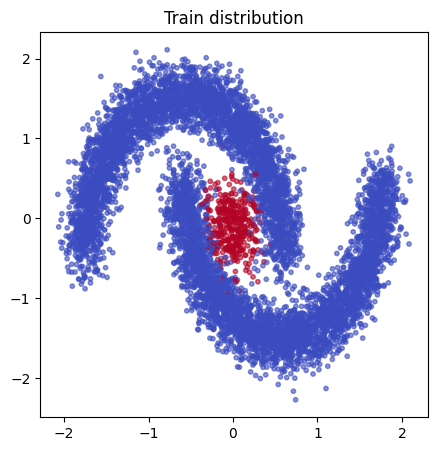

In [3]:
# Quick visual sanity check
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), s=10, cmap='coolwarm', alpha=0.6)
plt.title("Train distribution")
plt.show()

### 3.3 Entraînement des modèles

D'après le pipeline TarDiff, il faut d'abord entraîner le **modèle downstream** sur notre jeu d'entrainement pour ensuite pouvoir calculer le cache de gradients sur le jeu de validation. De même, le **modèle de diffusion** conditionnelle est aussi à entraîner sur le train en amont.

C'est ce que l'on va faire dans cette section.

#### 3.3.1 Modèles et configurations

On définit d’abord les architectures minimales et les hyperparamètres d'entraînement.

In [4]:
# models 
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class SimpleClassifierV0(nn.Module): # debbuging purposes - never used 
    # linear classifier
    def __init__(self, input_dim=2, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class SimpleDiffusionNet(nn.Module):
    def __init__(self, t_dim=16):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(2 + t_dim + 1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.float())
        y_emb = y.view(-1, 1).float()
        x_in = torch.cat([x, t_emb, y_emb], dim=1)
        return self.net(x_in)


class DDPMScheduler:
    def __init__(self, num_timesteps=50, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t].view(-1, 1)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t].view(-1, 1)
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,)).to(self.device)


#### 3.3.2 Entraînement 

On entraîne d'abord le classifieur, puis le modèle de diffusion conditionnelle.

Commencons par définir les fonctions d'entraînement et d'évaluation pour les deux modèles.

In [5]:
# Training utils

@dataclass
class TrainConfig:
    clf_epochs: int = 30
    diff_epochs: int = 50
    clf_lr: float = 1e-3
    diff_lr: float = 1e-3
    timesteps: int = 50


def train_classifier(model, loader, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.clf_lr)
    crit = nn.CrossEntropyLoss()
    for _ in range(cfg.clf_epochs):
        for x, y in loader:
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()


def train_diffusion(model, loader, scheduler: DDPMScheduler, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.diff_lr)
    crit = nn.MSELoss()
    for _ in range(cfg.diff_epochs):
        for x, y in loader:
            opt.zero_grad()
            t = scheduler.sample_timesteps(x.shape[0]).view(-1, 1)
            x_t, noise = scheduler.noise(x, t)
            noise_pred = model(x_t, t, y)
            loss = crit(noise_pred, noise)
            loss.backward()
            opt.step()


def eval_classifier(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
    acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
    recall_0 = recall_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=0)
    precision_0 = precision_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=0)
    f1_0 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=0)
    recall_1 = recall_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    precision_1 = precision_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    f1_1 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    auroc = roc_auc_score(y.cpu().numpy(), probs.cpu().numpy())
    auprc = average_precision_score(y.cpu().numpy(), probs.cpu().numpy())
    return dict(acc=acc, recall_0=recall_0, precision_0=precision_0, f1_0=f1_0, recall_1=recall_1, precision_1=precision_1, f1_1=f1_1, auroc=auroc, auprc=auprc)


cfg_train = TrainConfig()
scheduler = DDPMScheduler(num_timesteps=cfg_train.timesteps, device=DEVICE)

Maintenant, on peut entraîner le classifieur downstream.

In [6]:
cfg_train = TrainConfig()

clf = SimpleClassifier().to(DEVICE)
train_classifier(clf, train_loader, cfg_train)
metrics_real = eval_classifier(clf, X_test, y_test)
print("Downstream on real :", metrics_real)

Downstream on real : {'acc': 0.95, 'recall_0': 1.0, 'precision_0': 0.95, 'f1_0': 0.9743589743589743, 'recall_1': 0.0, 'precision_1': 0.0, 'f1_1': 0.0, 'auroc': 0.9616842105263157, 'auprc': 0.6848606681256558}


c:\Users\issa\anaconda3\envs\torch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evidément, on tombe dans le cas classique de la classification binaire sur un jeu fortement déséquilibré. 

Le modèle est "parresseux" et prédit toujours la classe majoritaire (0) pour maximiser son accuracy.

On obtient donc 95% d'accuracy et de précision avec un recall parfait sur la classe majoritaire, et 0% de recall, précision et F1 sur la classe minoritaire.

Ce n'est pas un cas marginal dans le contexte médical, et on va maintenant montrer que TarDiff permet de résoudre ce problème. 

Entraînons le modèle de diffusion conditionnelle sur le train.

In [7]:
# --- Training ---
scheduler_bal = DDPMScheduler(num_timesteps=cfg_train.timesteps, device=DEVICE)

diff_model_bal = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model_bal, train_loader, scheduler_bal, cfg_train)
print("Diffusion trained.")

Diffusion trained.


On vérifie que le DDPM conditionnel apprend correctement $p(x|y)$.

In [8]:
from scipy.stats import wasserstein_distance

def sample_standard(model, scheduler, n_samples, c):
    """Génération standard sans guidage (w=0) pour validation."""
    model.eval()
    with torch.no_grad():
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y = torch.full((n_samples,), c, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            noise_pred = model(x, t, y)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred) + torch.sqrt(beta) * noise
    return x


def check_distribution_metrics(real_samples, fake_samples, name=""):
    print(f"--- Check Distribution: {name} ---")
    
    mu_dist = torch.norm(real_samples.mean(dim=0) - fake_samples.mean(dim=0)).item()
    std_dist = torch.norm(real_samples.std(dim=0) - fake_samples.std(dim=0)).item()
    print(f"Diff Mean (L2): {mu_dist:.4f}")
    print(f"Diff Std  (L2): {std_dist:.4f}")
    
    wd0 = wasserstein_distance(real_samples[:,0].cpu().numpy(), fake_samples[:,0].cpu().numpy())
    wd1 = wasserstein_distance(real_samples[:,1].cpu().numpy(), fake_samples[:,1].cpu().numpy())
    print(f"Wasserstein Dist | Dim0: {wd0:.4f}, Dim1: {wd1:.4f}")
    
    return mu_dist, std_dist, wd0, wd1

Generating validation samples...
--- Check Distribution: Balanced Class 0 ---
Diff Mean (L2): 0.0318
Diff Std  (L2): 0.0416
Wasserstein Dist | Dim0: 0.0851, Dim1: 0.0415
--- Check Distribution: Balanced Class 1 ---
Diff Mean (L2): 0.0424
Diff Std  (L2): 0.0844
Wasserstein Dist | Dim0: 0.0722, Dim1: 0.0356


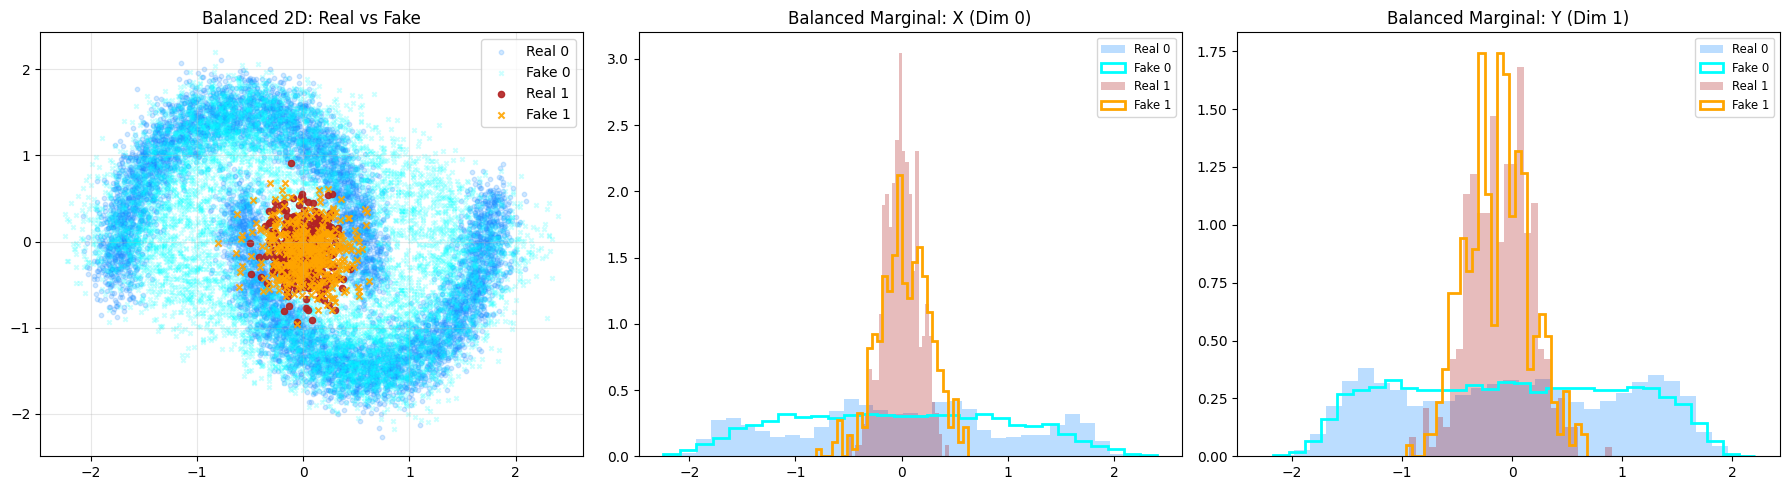

In [9]:
# --- Sanity Checks ---
print("Generating validation samples...")

X_maj_real_bal = X_train[y_train == 0]
X_maj_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_maj_real_bal), 0)

X_min_real_bal = X_train[y_train == 1]
X_min_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_min_real_bal), 1)

check_distribution_metrics(X_maj_real_bal, X_maj_gen_bal, "Balanced Class 0")
check_distribution_metrics(X_min_real_bal, X_min_gen_bal, "Balanced Class 1")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Balanced 2D: Real vs Fake")
axes[0].scatter(X_maj_real_bal[:,0].cpu(), X_maj_real_bal[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen_bal[:,0].cpu(), X_maj_gen_bal[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real_bal[:,0].cpu(), X_min_real_bal[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen_bal[:,0].cpu(), X_min_gen_bal[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Balanced Marginal: {name}")
    ax.hist(X_maj_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    ax.hist(X_maj_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    ax.hist(X_min_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    ax.hist(X_min_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

On voit que les échantillons générés sont relativement bien distribués selon la classe conditionnelle.

### 3.4 Génération ciblée par influence

A ce stade, on a :
- le classifieur entraîné,
- le modèle de diffusion entraîné,

Il nous reste plus qu'à calculer le cache de gradients $G$ à partir du guide set pour pouvoir faire de la génération influencée. 

#### 3.4.1 Cache de gradients

Là, on rentre dans la spécificité de TarDiff : on calcule le cache de gradients $G$ à partir du guide set.

Pour rappel :

$$
G \;=\; \frac{1}{|\mathcal{D}_{\text{guide}}|}\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}\nabla_{\phi}\ell_T(x_g,y_g;\phi^*).
$$

En pratique, on **somme les gradients du classifieur** sur tout le guide set, puis on **normalise** ce vecteur global (L2). Ce cache sera ensuite utilisé dans le produit scalaire $\nabla_\phi \ell_T(x,y;\phi^*) \cdot G$ pour construire le terme de guidage.

In [10]:
# --- Influence Cache Computation ---

def _normalize_grads(grads, eps=1e-6):
    """L2 normalization across all parameter gradients (as in official code)."""
    total_norm = torch.sqrt(sum((g ** 2).sum() for g in grads))
    return [g / (total_norm + eps) for g in grads]

def compute_influence_cache(classifier, loader):
    classifier.eval()
    crit = nn.CrossEntropyLoss(reduction="sum")

    params = list(classifier.parameters())
    total_loss = torch.tensor(0.0, device=DEVICE)

    for x_g, y_g in loader:
        x_g, y_g = x_g.to(DEVICE), y_g.to(DEVICE)
        logits = classifier(x_g)
        total_loss += crit(logits, y_g)

    grads = torch.autograd.grad(total_loss, params, allow_unused=True) # compute gradients
    filtered = [(p, g) for p, g in zip(params, grads) if g is not None] # filter out None grads
    if not filtered:
        raise ValueError("No parameter received gradient!")

    filtered_params, filtered_grads = zip(*filtered) # unzip filtered parameters and gradients
    normed_grads = _normalize_grads(filtered_grads)

    G_cache = {
        name: g
        for (name, _), g in zip(classifier.named_parameters(), normed_grads) 
        if g is not None
    }
    return G_cache 


In [11]:
G_cache_bal = compute_influence_cache(clf, guide_loader)
print("Influence cache norms :", {k: float(v.norm().item()) for k, v in G_cache_bal.items()})

Influence cache norms : {'net.0.weight': 0.5044213533401489, 'net.0.bias': 0.5249778032302856, 'net.2.weight': 0.45742902159690857, 'net.2.bias': 0.5106037259101868}


#### 3.4.2 Génération influencée

On a maintenant :
- le **modèle de diffusion conditionnel** entraîné,
- le **classifieur downstream**,
- le **cache de gradients $G$** calculé sur le jeu de validation.

On peut donc injecter le terme de guidage dans le reverse process pour obtenir une génération **orientée par l’influence**. Ci-dessous, on implémente la fonction de sampling TarDiff qui ajoute $w\,J_t$ à la moyenne du DDPM.


In [12]:
# --- TarDiff Sampling ---

def tardiff_sample(model, scheduler, classifier, G_cache, n_samples=200, target_class=1, w=10.0):
    """
    J = grad_x [ <norm(grad_phi l(x,y)), norm(G)> ]
    """
    model.eval()
    classifier.eval()
    crit_clf = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        # Start from pure Gaussian noise and fix the target class.
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y_cond = torch.full((n_samples,), target_class, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            # Predict noise with the conditional diffusion model.
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            predicted_noise = model(x, t, y_cond)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            # Compute the DDPM mean (x_recon) and the standard noise term.
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x_recon = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise)
            
            # Compute the influence-guidance direction J_t (if w != 0).
            J = torch.zeros_like(x)
            if w != 0:  # Apply influence guidance
                with torch.enable_grad():
                    x_in = x.detach().clone()
                    x_in.requires_grad = True
                    
                    out_clf = classifier(x_in)
                    loss = crit_clf(out_clf, y_cond)
                    
                    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, allow_unused=True)
                    filtered = [(p, g) for p, g in zip(classifier.parameters(), grads_phi) if g is not None]
                    if not filtered:
                        raise ValueError("No parameter received gradient!")
                    _, grads_phi = zip(*filtered)
                    grads_phi = _normalize_grads(grads_phi)
                    
                    # Influence score = dot product between per-sample grads and cached G.
                    influence_score = 0
                    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
                        if name in G_cache:
                            influence_score += torch.sum(g_phi * G_cache[name])  # dot product

                    # J_t is the gradient of the influence score w.r.t. x.
                    J = torch.autograd.grad(influence_score, x_in)[0]
                
                J = J.detach()
            
            # Final update: DDPM mean + guidance drift + noise.
            sigma_t = torch.sqrt(beta)
            x = x_recon + (w * J) + sigma_t * noise
            
    return x.detach()


Pour visualiser l'apport de la méthode, on va afficher les échantillons générés pour différentes valeurs de $w$, en les comparant aux vraies données d'entraînement pour les deux classes.

Sampling 5000 points per w (balanced)...


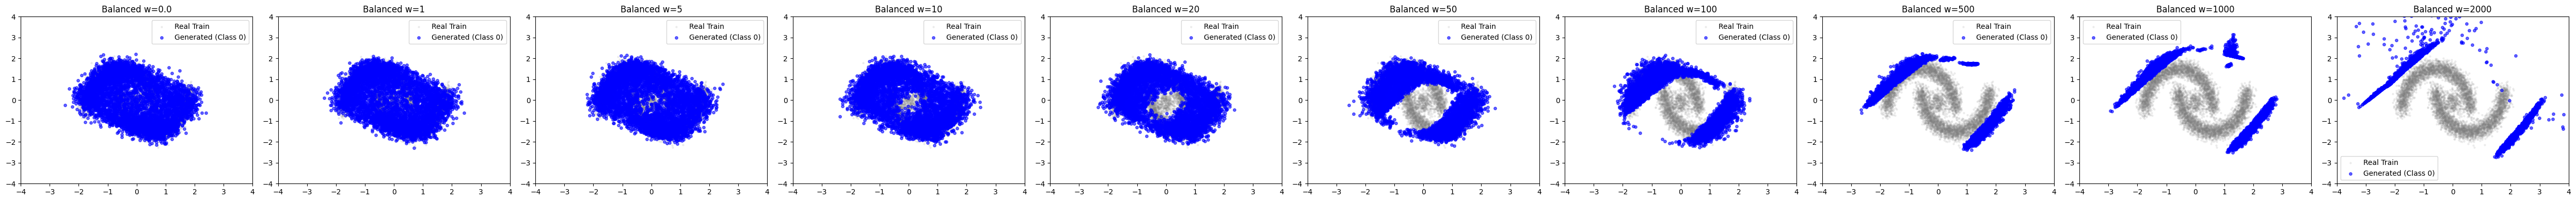

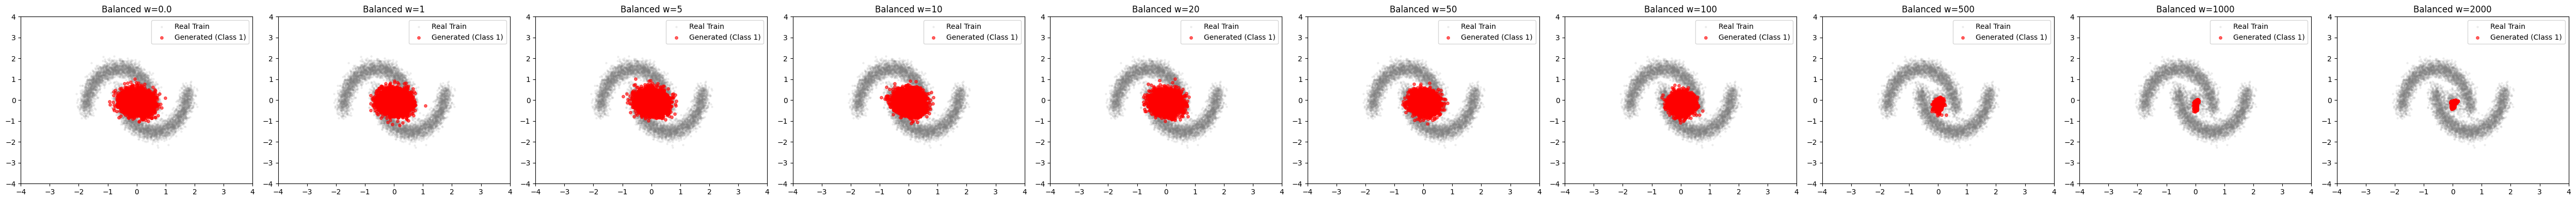

In [17]:
# --- Guidance Sweep ---
N_GEN_BAL = 5000
w_values_bal = [0.0, 1, 5, 10, 20, 50, 100, 500, 1000, 2000]
print(f"Sampling {N_GEN_BAL} points per w (balanced)...")

def guidance_sweep(model, scheduler, classifier, G_cache, w_values, n_samples, target_class):
    samples_by_w = {}
    for w in w_values:
        samples_by_w[w] = tardiff_sample(model, scheduler, classifier, G_cache, n_samples=n_samples, target_class=target_class, w=w)
    return samples_by_w

samples_bal_0 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=0
)

def plot_res_with_train(X_train_ref, samples, title, color, class_label, ax):
    ax.scatter(X_train_ref[:, 0].cpu(), X_train_ref[:, 1].cpu(), c='gray', s=5, alpha=0.1, label='Real Train')
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), c=color, s=15, alpha=0.6, label=f'Generated (Class {class_label})')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_0[w], f"Balanced w={w}", "blue", 0, ax)
plt.tight_layout()
plt.show()

samples_bal_1 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=1
)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_1[w], f"Balanced w={w}", "red", 1, ax)
plt.tight_layout()
plt.show()

Analyse Visuelle : 

On observe l'évolution des distributions générées (Bleu pour la classe majoritaire, Rouge pour la minoritaire) à mesure que le poids de guidance $w$ augmente (de gauche à droite)

- À faible guidance ($w=0$ à $5$) : Les points générés (bleus et rouges) recouvrent relativement fidèlement (limité par la précision du modèle de diffusion) la distribution réelle (en gris). Le modèle agit comme un générateur classique (DDPM) et préserve la variance et la forme des données.
- À forte guidance ($w \geq 100$) : On observe une distorsion spectaculaire.
    - Classe 0 (Bleu) : Les points sont repoussés loin de la frontière de décision centrale. La forme en "double lune" est brisée pour former des lignes denses dans les zones de "sécurité maximale".
    - Classe 1 (Rouge) : Le cluster s'effondre sur lui-même (mode collapse). Il devient une singularité ultra-dense au centre de la zone minoritaire
    
> Interprétation : Ceci illustre parfaitement le mécanisme de TarDiff. Le gradient $\nabla_{\phi}l$ ne pousse pas le modèle à être réaliste, mais classifiable. Pour minimiser la perte, le moyen le plus efficace est de générer des "super-prototypes" : des exemples caricaturaux, sans aucune ambiguïté, situés le plus loin possible de la frontière de décision adverse.

Note : ça peut paraître contre intuitif au premier abord, puisque l'on pourrait s'attendre à ce que les points soient justement poussés vers la frontière de décision pour maximiser l'information et aider le classifieur. 

### 3.7 Utilité downstream 

On mesure l'utilité des échantillons synthétiques pour la tâche downstream (classification binaire) de deux manières : 
- TSTR - Training on Synthetic, Testing on Real : on entraîne un classifieur sur les données synthétiques générées, puis on l'évalue sur le test set réel.
- TSRTR - Training on Synthetic + Real, Testing on Real : on entraîne un classifieur sur les données réelles augmentées des données synthétiques générées, puis on l'évalue sur le test set réel.

In [ ]:
# --- Downstream Utility : TSTR ---
print("\n--- Downstream Utility - TSTR ---")

import pandas as pd

# Train classifiers per w on synthetic-only data (single run)
rows_tstr = [{
    "w": "real-only",
    "acc": metrics_real["acc"],
    "precision": metrics_real["precision_1"],
    "recall": metrics_real["recall_1"],
    "f1": metrics_real["f1_1"],
    "auroc": metrics_real["auroc"],
    "auprc": metrics_real["auprc"],
}]
results_tstr = {}
preds_tstr = {}

for w in w_values_bal:
    X_syn_0 = samples_bal_0[w]
    X_syn_1 = samples_bal_1[w]

    y_syn_0 = torch.zeros(len(X_syn_0), dtype=torch.long).to(DEVICE)
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)

    X_syn = torch.cat([X_syn_0, X_syn_1])
    y_syn = torch.cat([y_syn_0, y_syn_1])

    loader_syn = DataLoader(TensorDataset(X_syn, y_syn), batch_size=64, shuffle=True)
    clf_syn = SimpleClassifier().to(DEVICE)
    train_classifier(clf_syn, loader_syn, TrainConfig(clf_epochs=30))
    metrics_syn = eval_classifier(clf_syn, X_test, y_test)

    with torch.no_grad():
        logits = clf_syn(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu()
        preds = torch.argmax(logits, dim=1).detach().cpu()

    preds_tstr[w] = {"preds": preds, "probs": probs}
    results_tstr[w] = metrics_syn

    rows_tstr.append({
        "w": w if w != 0.0 else "DDPM",
        "acc": metrics_syn["acc"],
        "precision": metrics_syn["precision_1"],
        "recall": metrics_syn["recall_1"],
        "f1": metrics_syn["f1_1"],
        "auroc": metrics_syn["auroc"],
        "auprc": metrics_syn["auprc"],
    })

results_tstr_df = pd.DataFrame(rows_tstr)
best_w_tstr = max(results_tstr, key=lambda k: results_tstr[k]["auroc"])
best_preds_tstr = preds_tstr[best_w_tstr]["preds"]
best_probs_tstr = preds_tstr[best_w_tstr]["probs"]

# Display as table (one row per w)
results_tstr_df


--- Downstream Utility (Balanced 50/50) - TSTR ---


,w,acc,precision,recall,f1,auroc,auprc
0,real-only,0.9500,0.000000,0.00,0.000000,0.961684,0.684861
1,DDPM,0.8965,0.324590,0.99,0.488889,0.991721,0.896367
2,1,0.8770,0.287791,0.99,0.445946,0.991179,0.893189
3,5,0.8865,0.304615,0.99,0.465882,0.991174,0.885889
4,10,0.8800,0.294118,1.00,0.454545,0.993000,0.909486
5,20,0.8470,0.246305,1.00,0.395257,0.991363,0.893057
6,50,0.7915,0.193424,1.00,0.324149,0.986895,0.853089
7,100,0.7425,0.162602,1.00,0.279720,0.972953,0.752181
8,500,0.6910,0.139276,1.00,0.244499,0.943508,0.553613
9,1000,0.6545,0.126422,1.00,0.224467,0.899218,0.209297


TSTR: best w = 5 (AUROC=0.9919)


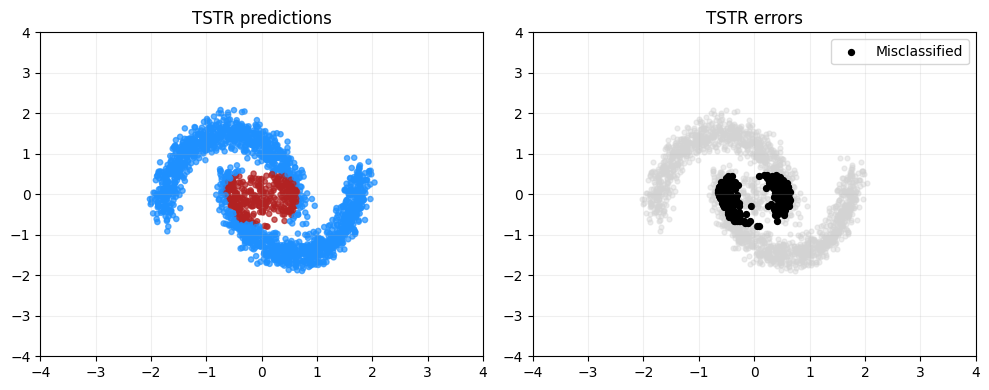

In [ ]:
# --- TSTR predictions visualization (best w) ---
print(f"TSTR: best w = {best_w_tstr} (AUROC={results_tstr[best_w_tstr]['auroc']:.4f})")

X_test_cpu = X_test.detach().cpu()
y_test_cpu = y_test.detach().cpu()
preds = best_preds_tstr
errors = preds != y_test_cpu

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = np.where(preds.numpy() == 1, "firebrick", "dodgerblue")
axes[0].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c=colors, s=14, alpha=0.7)
axes[0].set_title("TSTR predictions")
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].grid(alpha=0.2)

axes[1].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c="lightgray", s=12, alpha=0.4)
axes[1].scatter(X_test_cpu[errors][:, 0], X_test_cpu[errors][:, 1], c="black", s=18, label="Misclassified")
axes[1].set_title("TSTR errors")
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

Comme on le voyait sur les plots $w=1000$ ou $2000$, les données synthétiques perdent progressivement toute leur diversité (variance faible) et la ressemblance avec les données réelles. Un classifieur entraîné uniquement sur ces "caricatures" rouges et bleues n'apprend jamais à gérer les cas limites ou le bruit des données réelles. 

Résultat : Quand on le teste sur le réel, il échoue (Accuracy chute de 0.95 à 0.59).

Par contre, on remarque que pour des valeurs intermédiaires de $w$ l'AUROC et l'AUPRC explosent (> 0.99 pour l'AUC et > 0.87 pour l'AUPRC contre 0.96 et 0.68 respectivement sur les vraies données). Ce n'est pas du tout incohérent avec la dégradation de l'accuracy puisque ce sont des mesures de ranking (ordre). Elles évaluent si le modèle est capable de classer un exemple positif plus haut qu'un exemple négatif, quel que soit le score exact.

De même, le recall passe à 1.0 directement, ce qui signifie que tous les exemples positifs sont détectés (aucun faux négatif), au prix d'une baisse de précision (plus de faux positifs).

> Observation partielle : Tardiff semble très efficace pour maximiser la détectabilité (ranking) des événements rares, au prix d'une perte de précision sur la frontière de décision exacte.

Testons maintenant l'impact de l'augmentation avec les données synthétiques sur un entraînement mixte (TSRTR).

In [24]:
# --- Downstream Utility : TSRTR ---
print("\n--- Downstream Utility - TSRTR ---")

import pandas as pd

# Train classifiers per w on train + synthetic data (single run)
rows_tsrtr = [{
    "w": "real-only",
    "acc": metrics_real["acc"],
    "precision": metrics_real["precision_1"],
    "recall": metrics_real["recall_1"],
    "f1": metrics_real["f1_1"],
    "auroc": metrics_real["auroc"],
    "auprc": metrics_real["auprc"],
}]
results_tsrtr = {}
preds_tsrtr = {}

for w in w_values_bal:
    X_syn_0 = samples_bal_0[w]
    X_syn_1 = samples_bal_1[w]

    y_syn_0 = torch.zeros(len(X_syn_0), dtype=torch.long).to(DEVICE)
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)

    X_syn = torch.cat([X_syn_0, X_syn_1])
    y_syn = torch.cat([y_syn_0, y_syn_1])

    X_aug = torch.cat([X_train, X_syn])
    y_aug = torch.cat([y_train, y_syn])

    loader_aug = DataLoader(TensorDataset(X_aug, y_aug), batch_size=64, shuffle=True)
    clf_aug = SimpleClassifier().to(DEVICE)
    train_classifier(clf_aug, loader_aug, TrainConfig(clf_epochs=30))
    metrics_aug = eval_classifier(clf_aug, X_test, y_test)

    with torch.no_grad():
        logits = clf_aug(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu()
        preds = torch.argmax(logits, dim=1).detach().cpu()

    preds_tsrtr[w] = {"preds": preds, "probs": probs}
    results_tsrtr[w] = metrics_aug

    rows_tsrtr.append({
        "w": w,
        "acc": metrics_aug["acc"],
        "precision": metrics_aug["precision_1"],
        "recall": metrics_aug["recall_1"],
        "f1": metrics_aug["f1_1"],
        "auroc": metrics_aug["auroc"],
        "auprc": metrics_aug["auprc"],
    })

results_tsrtr_df = pd.DataFrame(rows_tsrtr)
best_w_tsrtr = max(results_tsrtr, key=lambda k: results_tsrtr[k]["f1_1"])
best_preds_tsrtr = preds_tsrtr[best_w_tsrtr]["preds"]
best_probs_tsrtr = preds_tsrtr[best_w_tsrtr]["probs"]

# Display as table (one row per w)
results_tsrtr_df


--- Downstream Utility - TSRTR ---


,w,acc,precision,recall,f1,auroc,auprc
0,real-only,0.9500,0.000000,0.00,0.000000,0.961684,0.684861
1,0.0,0.9535,0.518919,0.96,0.673684,0.994879,0.928155
2,1,0.9575,0.541436,0.98,0.697509,0.995126,0.933205
3,5,0.9570,0.538889,0.97,0.692857,0.995068,0.930733
4,10,0.9585,0.548023,0.97,0.700361,0.995216,0.929927
5,20,0.9560,0.532258,0.99,0.692308,0.995174,0.927241
6,50,0.9675,0.607362,0.99,0.752852,0.995821,0.933303
7,100,0.9735,0.662069,0.96,0.783673,0.996153,0.940505
8,500,0.9875,0.903226,0.84,0.870466,0.995053,0.940599
9,1000,0.9875,0.921348,0.82,0.867725,0.995763,0.945800


TSRTR: best w = 2000 (F1=0.8912)


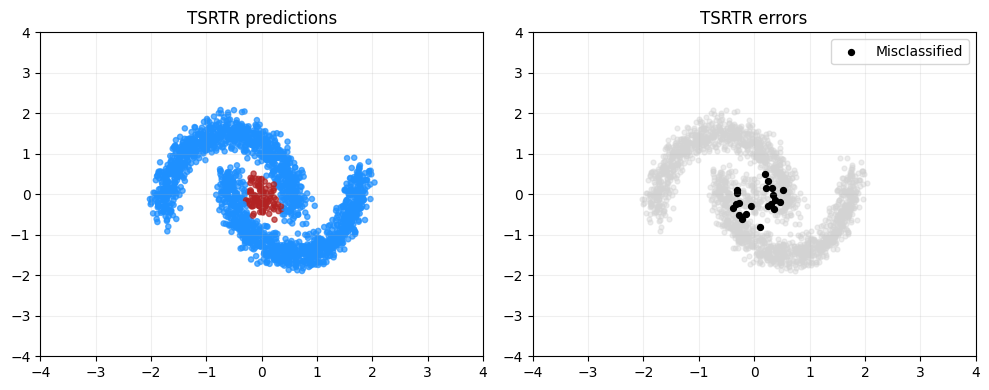

In [25]:
# --- TSRTR predictions visualization (best w) ---
print(f"TSRTR: best w = {best_w_tsrtr} (F1={results_tsrtr[best_w_tsrtr]['f1_1']:.4f})")

X_test_cpu = X_test.detach().cpu()
y_test_cpu = y_test.detach().cpu()
preds = best_preds_tsrtr
errors = preds != y_test_cpu

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = np.where(preds.numpy() == 1, "firebrick", "dodgerblue")
axes[0].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c=colors, s=14, alpha=0.7)
axes[0].set_title("TSRTR predictions")
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].grid(alpha=0.2)

axes[1].scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c="lightgray", s=12, alpha=0.4)
axes[1].scatter(X_test_cpu[errors][:, 0], X_test_cpu[errors][:, 1], c="black", s=18, label="Misclassified")
axes[1].set_title("TSRTR errors")
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

C'est là où l'on voit tout l'intérêt de TarDiff !

Contrairement à l'expérience précédente (TSTR) où le remplacement total des données réelles entraînait une perte de calibration (chute d'Accuracy), l'ajout de données synthétiques aux données réelles (Augmentation) produit ici les meilleurs résultats absolus.

**Le "Meilleur des Deux Mondes"**
- Accuracy (Exactitude) : Elle ne chute plus, elle augmente ! Elle passe de 0.957 ($w=0$, baseline) à près de 0.990 ($w=500$).
- Précision / Recall / F1 : Ils ne font qu'augmenter avec $w$, avec un gros bon de précision après $w=500$. Les cas rares sont donc mieux détectés mais de manière précise !
- AUPRC / AUROC : Elles sont extrêment élevées (> 0.94 pour l'AUPRC et > 0.995 pour l'AUROC).

Ces deux métriques d'AUPRC et d'AUROC sont particulièrement importantes dans les contextes médicaux déséquilibrés, car elles reflètent la capacité du modèle à détecter correctement les cas rares sans être influencé par la majorité des cas négatifs.

**Pourquoi l'Accuracy remonte-t-elle ici ?**

C'est l'effet correctif des données réelles : Les données synthétiques (TarDiff) agissent comme des "ancres" ou des "Super-Exemples". Elles sont caricaturales et forcent le modèle à créer une frontière de décision très nette autour de la classe minoritaire. Les données réelles apportent la "variance" et le "bruit" nécessaires. Elles empêchent le modèle d'être trop rigide (overconfident) et lui apprennent à gérer les cas limites flous. Et on remarque que plus le traît est tiré i.e plus $w$ est grand (même à 2000), plus l'accuracy remonte.

**Conclusion**

TarDiff ne doit pas être vu comme un outil de remplacement de données (anonymisation parfaite), mais comme un outil d'optimisation de l'utilité clinique. Il transforme le processus de génération : au lieu de simplement imiter la réalité (qui contient des biais et des déséquilibres), il la distord intelligemment pour maximiser la performance diagnostique sur les cas qui comptent le plus

### 3.8 Analyse de la méthode et des hyperparamètres

Maintenant que nous avons validé le pipeline Tardiff et montré son intérêt dans le cas déséquilibré, nous allons faire quelques analyses supplémentaires notamment sur le choix des hyperparamètres, avant d'appliquer la méthode sur des données ECG réelles.

#### 3.8.1 Impact de la proportion de données synthétiques (TSRTR)

On fixe un $w$ performant, puis on fait varier la **proportion de données synthétiques ajoutées au train** pour observer l'effet sur les métriques downstream.

Les données synthétiques respectent le même ratio de classes que le train réel i.e 95% vs 5%.

In [33]:
# --- 3.8.1 Impact de la proportion synthétique (TSRTR) ---
print("\n--- Impact proportion synthétique (TSRTR) ---")

import pandas as pd
import numpy as np

w_ratio = best_w_tsrtr if "best_w_tsrtr" in globals() else (best_w_tstr if "best_w_tstr" in globals() else 50)
if isinstance(w_ratio, str):
    try:
        w_ratio = float(w_ratio)
    except ValueError:
        w_ratio = 50
if w_ratio not in samples_bal_0:
    w_ratio = list(samples_bal_0.keys())[0]

ratios = [0.0, 0.25, 0.5, 1.0, 1.5, 2.0]
n_real_0 = int((y_train == 0).sum().item())
n_real_1 = int((y_train == 1).sum().item())
n_runs = 10

def sample_pool(pool, n):
    if n <= 0:
        return pool[:0]
    idx = torch.randperm(len(pool))[:n]
    return pool[idx]

rows_ratio = []
for run in range(n_runs):
    torch.manual_seed(42 + run)
    np.random.seed(42 + run)
    for r in ratios:
        n_syn_0 = min(int(n_real_0 * r), len(samples_bal_0[w_ratio]))
        n_syn_1 = min(int(n_real_1 * r), len(samples_bal_1[w_ratio]))
        X_syn_0 = sample_pool(samples_bal_0[w_ratio], n_syn_0)
        X_syn_1 = sample_pool(samples_bal_1[w_ratio], n_syn_1)

        if n_syn_0 + n_syn_1 > 0:
            X_syn = torch.cat([X_syn_0, X_syn_1])
            y_syn = torch.cat([
                torch.zeros(len(X_syn_0), dtype=torch.long).to(DEVICE),
                torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE),
            ])
            X_aug = torch.cat([X_train, X_syn])
            y_aug = torch.cat([y_train, y_syn])
        else:
            X_aug, y_aug = X_train, y_train

        loader_aug = DataLoader(TensorDataset(X_aug, y_aug), batch_size=64, shuffle=True)
        clf_aug = SimpleClassifier().to(DEVICE)
        train_classifier(clf_aug, loader_aug, TrainConfig(clf_epochs=30))
        metrics_aug = eval_classifier(clf_aug, X_test, y_test)

        rows_ratio.append({
            "run": run,
            "ratio_syn/real": r,
            "n_syn": int(n_syn_0 + n_syn_1),
            "acc": metrics_aug["acc"],
            "precision": metrics_aug["precision_1"],
            "recall": metrics_aug["recall_1"],
            "f1": metrics_aug["f1_1"],
            "auroc": metrics_aug["auroc"],
            "auprc": metrics_aug["auprc"],
        })

ratio_df = pd.DataFrame(rows_ratio)
ratio_df

ratio_summary = ratio_df.groupby("ratio_syn/real")[["acc", "precision", "recall", "f1", "auroc", "auprc"]].agg(["mean", "std"]).reset_index()
ratio_summary


--- Impact proportion synthétique (TSRTR) ---


ratio_syn/real      acc           precision           recall            \
                     mean       std      mean       std   mean       std   
0           0.00  0.97685  0.006037  0.976308  0.014578  0.551  0.124940   
1           0.25  0.98610  0.002145  0.964692  0.012565  0.750  0.050553   
2           0.50  0.98775  0.001230  0.952336  0.009729  0.795  0.028771   
3           1.00  0.98785  0.000851  0.950171  0.008689  0.799  0.017920   
4           1.50  0.98730  0.001975  0.945502  0.010529  0.792  0.045898   
5           2.00  0.98845  0.000685  0.945721  0.009935  0.816  0.016465   

         f1               auroc               auprc            
       mean       std      mean       std      mean       std  
0  0.695921  0.111352  0.995247  0.000603  0.931031  0.009255  
1  0.842753  0.030662  0.995591  0.000382  0.941669  0.002498  
2  0.866242  0.015758  0.995526  0.000572  0.941930  0.004599  
3  0.867920  0.010500  0.995806  0.000244  0.942778  0.003366  
4  0.861140  0.026500  0.995462  0.000280  0.941821  0.002876  
5  0.875941  0.008402  0.995541  0.000451  0.942885  0.003600

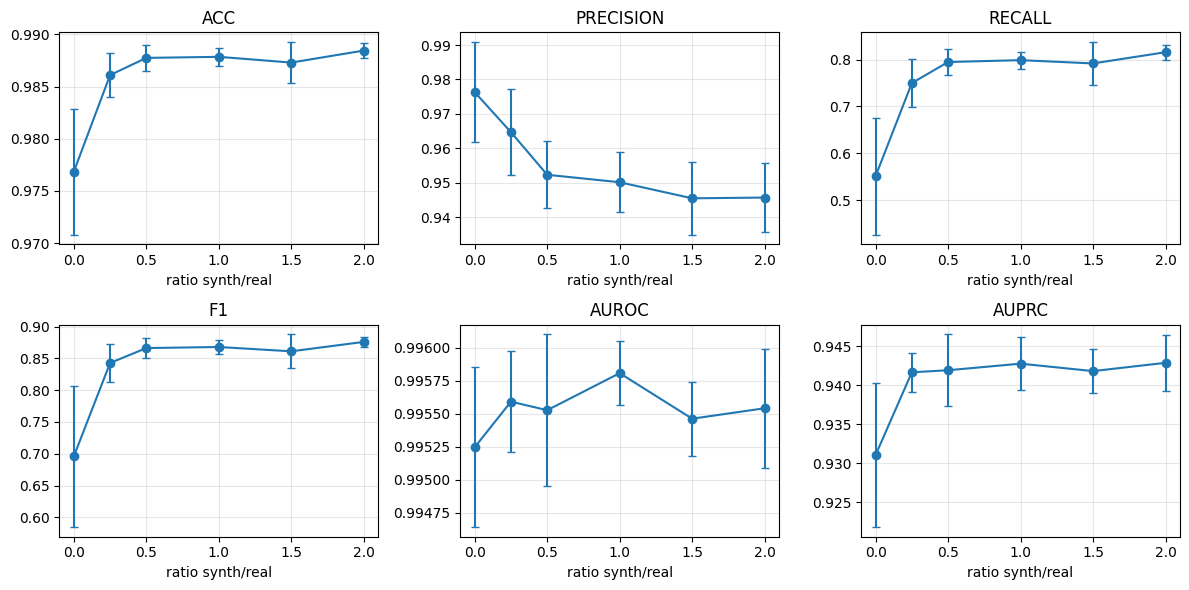

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()
for ax, metric in zip(axes, ["acc", "precision", "recall", "f1", "auroc", "auprc"]):
    mean_vals = ratio_summary[(metric, "mean")].values
    std_vals = ratio_summary[(metric, "std")].values
    ax.errorbar(ratio_summary["ratio_syn/real"], mean_vals, yerr=std_vals, marker="o", capsize=3)
    ax.set_title(metric.upper())
    ax.set_xlabel("ratio synth/real")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

La multiplicité de métriques permet de comprendre en détail l'impact de l'augmentation synthétique, même si elle complique le choix du ratio optimal. 

Ce qu'on remarque : 
- L'accuracy et le F1 score (de la classe minoritaire) augmentent clairement avec le ratio de synthétique avec une variance qui diminue. 
- La précision et le recall (de la classe minoritaire) sont inversement affectés puisque l'augmentation de l'un entraîne la diminution de l'autre. Mais, on remarque que la diminution en précision est très faible comparée à l'augmentation du recall. 
- L'AUPRC et l'AUROC restent très élevés et assez stables. 
- Plus on 

Sachant tout cela, on peut en conclure que le ratio optimal est en fait celui de 2. 

In [35]:
best_idx = ratio_df["f1"].idxmax()
best_row = ratio_df.loc[best_idx].copy()

print("\n=== Best run across ALL runs & ratios (max F1) ===")
print(f"run = {int(best_row['run'])}")
print(f"ratio_syn/real = {best_row['ratio_syn/real']}")
print(f"n_syn = {int(best_row['n_syn'])}")

metrics_cols = ["acc", "precision", "recall", "f1", "auroc", "auprc"]

# Optional: show as a 1-row dataframe (nice in notebooks)
best_run_df = pd.DataFrame([best_row[["run", "ratio_syn/real", "n_syn"] + metrics_cols]])
best_run_df


=== Best run across ALL runs & ratios (max F1) ===
run = 0
ratio_syn/real = 0.5
n_syn = 3999


,run,ratio_syn/real,n_syn,acc,precision,recall,f1,auroc,auprc
2,0.0,0.5,3999.0,0.99,0.954545,0.84,0.893617,0.995253,0.941436


In [37]:
# ...existing code...

print("\n--- Impact proportion synthétique (TSRTR) - TOTAL FIXE ---")

import pandas as pd
import numpy as np

w_ratio = best_w_tsrtr if "best_w_tsrtr" in globals() else (best_w_tstr if "best_w_tstr" in globals() else 50)
if isinstance(w_ratio, str):
    try:
        w_ratio = float(w_ratio)
    except ValueError:
        w_ratio = 50
if w_ratio not in samples_bal_0:
    w_ratio = list(samples_bal_0.keys())[0]

ratios = [0.0, 0.25, 0.5, 1.0, 1.5, 2.0]  # interpreted as syn/real within a fixed total
n_runs = 5

N_total = len(X_train)
p_real_1 = float((y_train == 1).float().mean().item())  # ~0.05
p_real_0 = 1.0 - p_real_1

idx_real_0 = torch.where(y_train == 0)[0]
idx_real_1 = torch.where(y_train == 1)[0]

def sample_from_indices(idxs, n):
    if n <= 0:
        return idxs[:0]
    perm = torch.randperm(len(idxs), device=idxs.device)[:n]
    return idxs[perm]

def sample_pool(pool, n):
    if n <= 0:
        return pool[:0]
    perm = torch.randperm(len(pool), device=pool.device)[:n]
    return pool[perm]

rows_ratio_fixed = []
for run in range(n_runs):
    torch.manual_seed(42 + run)
    np.random.seed(42 + run)

    for r in ratios:
        # r = N_syn / N_real_keep  => N_syn = r * N_real_keep and N_real_keep + N_syn = N_total
        # => N_real_keep = N_total / (1 + r), N_syn = N_total - N_real_keep
        if r == 0:
            n_syn = 0
            n_real_keep = N_total
        else:
            n_real_keep = int(round(N_total / (1.0 + r)))
            n_syn = N_total - n_real_keep

        # Keep real subset stratified (same class ratio as real train)
        n_real_keep_1 = int(round(n_real_keep * p_real_1))
        n_real_keep_0 = n_real_keep - n_real_keep_1

        sel0 = sample_from_indices(idx_real_0, n_real_keep_0)
        sel1 = sample_from_indices(idx_real_1, n_real_keep_1)

        X_real_keep = torch.cat([X_train[sel0], X_train[sel1]], dim=0)
        y_real_keep = torch.cat(
            [torch.zeros(len(sel0), dtype=torch.long, device=DEVICE),
             torch.ones(len(sel1), dtype=torch.long, device=DEVICE)],
            dim=0
        )

        # Synthetic: match the same 95/5 ratio
        n_syn_1 = int(round(n_syn * p_real_1))
        n_syn_0 = n_syn - n_syn_1

        n_syn_0 = min(n_syn_0, len(samples_bal_0[w_ratio]))
        n_syn_1 = min(n_syn_1, len(samples_bal_1[w_ratio]))

        X_syn_0 = sample_pool(samples_bal_0[w_ratio], n_syn_0)
        X_syn_1 = sample_pool(samples_bal_1[w_ratio], n_syn_1)

        if n_syn_0 + n_syn_1 > 0:
            X_syn = torch.cat([X_syn_0, X_syn_1], dim=0)
            y_syn = torch.cat(
                [torch.zeros(len(X_syn_0), dtype=torch.long, device=DEVICE),
                 torch.ones(len(X_syn_1), dtype=torch.long, device=DEVICE)],
                dim=0
            )
            X_aug = torch.cat([X_real_keep, X_syn], dim=0)
            y_aug = torch.cat([y_real_keep, y_syn], dim=0)
        else:
            X_aug, y_aug = X_real_keep, y_real_keep

        # Sanity: total fixed (unless the synthetic pools cap you)
        n_total_eff = len(X_aug)

        loader_aug = DataLoader(TensorDataset(X_aug, y_aug), batch_size=64, shuffle=True)
        clf_aug = SimpleClassifier().to(DEVICE)
        train_classifier(clf_aug, loader_aug, TrainConfig(clf_epochs=30))
        metrics_aug = eval_classifier(clf_aug, X_test, y_test)

        rows_ratio_fixed.append({
            "run": run,
            "ratio_syn/real": r,
            "n_total": int(n_total_eff),
            "n_real_keep": int(len(X_real_keep)),
            "n_syn": int(n_syn_0 + n_syn_1),
            "acc": metrics_aug["acc"],
            "precision": metrics_aug["precision_1"],
            "recall": metrics_aug["recall_1"],
            "f1": metrics_aug["f1_1"],
            "auroc": metrics_aug["auroc"],
            "auprc": metrics_aug["auprc"],
        })

ratio_fixed_df = pd.DataFrame(rows_ratio_fixed)
ratio_fixed_summary = ratio_fixed_df.groupby("ratio_syn/real")[["acc","precision","recall","f1","auroc","auprc"]].agg(["mean","std"]).reset_index()

ratio_fixed_df, ratio_fixed_summary

# ...existing code...


--- Impact proportion synthétique (TSRTR) - TOTAL FIXE ---


(    run  ratio_syn/real  n_total  n_real_keep  n_syn     acc  precision  \
 0     0            0.00     8000         8000      0  0.9640   1.000000   
 1     0            0.25     8000         6400   1600  0.9810   0.984375   
 2     0            0.50     8000         5333   2667  0.9840   0.972222   
 3     0            1.00     8000         4000   4000  0.9760   0.981481   
 4     0            1.50     8000         3200   4800  0.9715   0.977778   
 5     0            2.00     7925         2667   5258  0.9785   0.983051   
 6     1            0.00     8000         8000      0  0.9705   0.955556   
 7     1            0.25     8000         6400   1600  0.9790   0.967742   
 8     1            0.50     8000         5333   2667  0.9845   0.972603   
 9     1            1.00     8000         4000   4000  0.9805   0.969231   
 10    1            1.50     8000         3200   4800  0.9700   0.976190   
 11    1            2.00     7925         2667   5258  0.9830   0.945946   
 12    2    

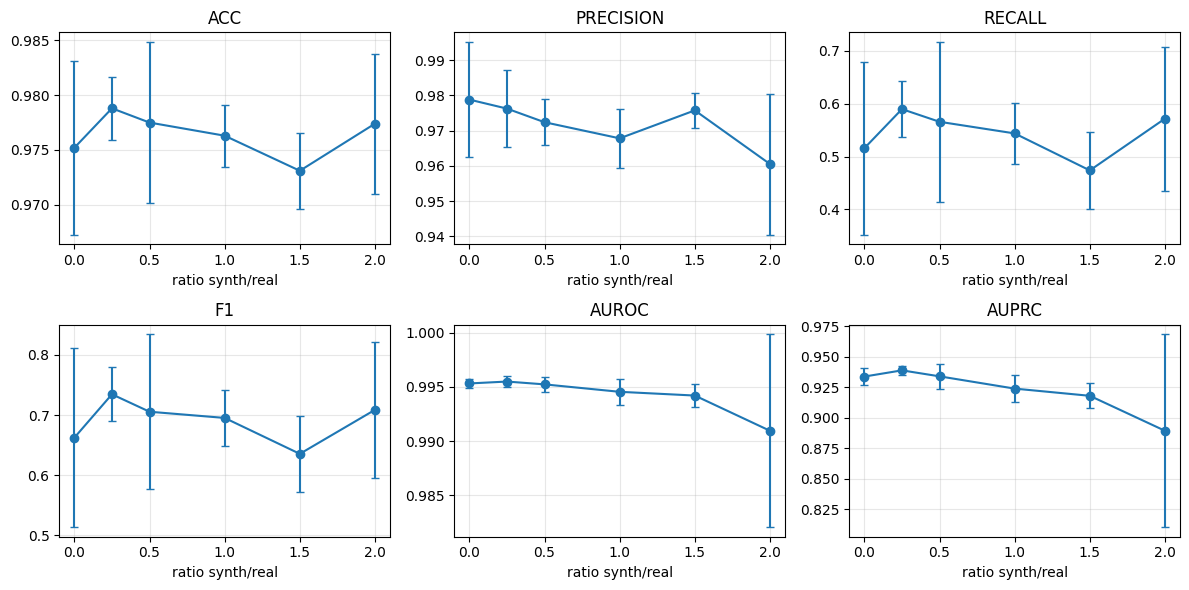

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()
for ax, metric in zip(axes, ["acc", "precision", "recall", "f1", "auroc", "auprc"]):
    mean_vals = ratio_fixed_summary[(metric, "mean")].values
    std_vals = ratio_fixed_summary[(metric, "std")].values
    ax.errorbar(ratio_fixed_summary["ratio_syn/real"], mean_vals, yerr=std_vals, marker="o", capsize=3)
    ax.set_title(metric.upper())
    ax.set_xlabel("ratio synth/real")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 3.8.2 Impact du choix du guide set

On compare ici trois variantes : un guide set composé uniquement de la **classe majoritaire**, uniquement de la **classe minoritaire**, et un guide **mixte 50/50**.


--- Impact du guide set ---


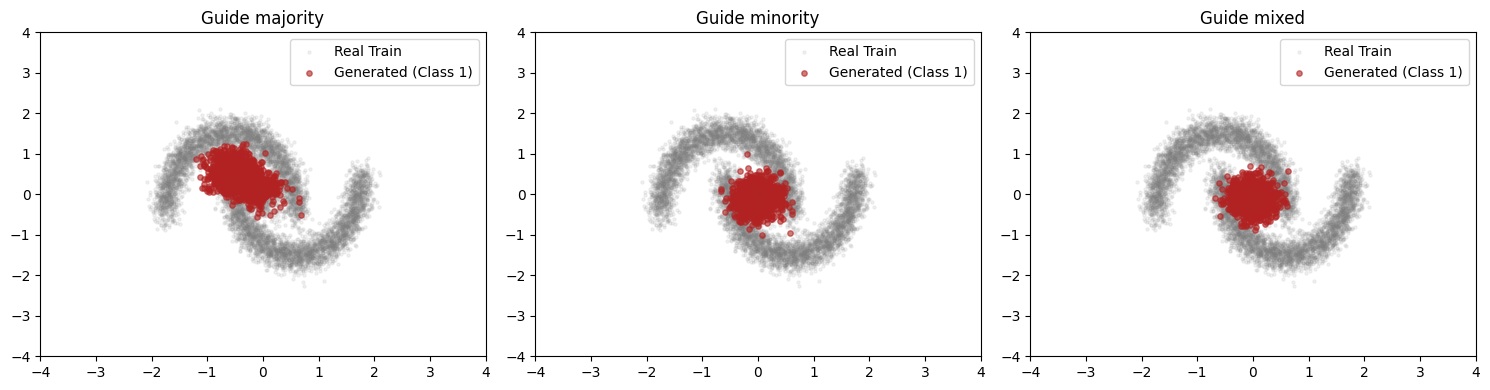

In [20]:
# --- 3.8.2 Impact du choix du guide set ---
print("\n--- Impact du guide set ---")

import numpy as np

def build_guide_loader(mode, max_size=None):
    if mode == "minority":
        X_guide = X_train[y_train == 1]
        y_guide = y_train[y_train == 1]
    elif mode == "majority":
        X_guide = X_train[y_train == 0]
        y_guide = y_train[y_train == 0]
    else:
        X0 = X_train[y_train == 0]
        X1 = X_train[y_train == 1]
        n = min(len(X0), len(X1))
        idx0 = torch.randperm(len(X0))[:n]
        idx1 = torch.randperm(len(X1))[:n]
        X_guide = torch.cat([X0[idx0], X1[idx1]])
        y_guide = torch.cat([torch.zeros(n, dtype=torch.long), torch.ones(n, dtype=torch.long)]).to(DEVICE)

    if max_size is not None and len(X_guide) > max_size:
        idx = torch.randperm(len(X_guide))[:max_size]
        X_guide = X_guide[idx]
        y_guide = y_guide[idx]

    return DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

guide_modes = ["majority", "minority", "mixed"]
guide_results = []
guide_samples = {}
w_guide = w_ratio
n_guide_samples = 1200
n_runs_guide = 5

for mode in guide_modes:
    loader = build_guide_loader(mode, max_size=1200)
    G_cache_mode = compute_influence_cache(clf_bal, loader)
    g_norms = [v.norm().item() for v in G_cache_mode.values()]
    g_norm = float(np.mean(g_norms)) if g_norms else 0.0

    samples_0 = tardiff_sample(diff_model_bal, scheduler_bal, clf_bal, G_cache_mode, n_samples=n_guide_samples, target_class=0, w=w_guide)
    samples_1 = tardiff_sample(diff_model_bal, scheduler_bal, clf_bal, G_cache_mode, n_samples=n_guide_samples, target_class=1, w=w_guide)
    guide_samples[mode] = {0: samples_0, 1: samples_1}

    X_syn = torch.cat([samples_0, samples_1])
    y_syn = torch.cat([torch.zeros(len(samples_0), dtype=torch.long).to(DEVICE), torch.ones(len(samples_1), dtype=torch.long).to(DEVICE)])
    loader_syn = DataLoader(TensorDataset(X_syn, y_syn), batch_size=64, shuffle=True)
    clf_syn = SimpleClassifier().to(DEVICE)
    train_classifier(clf_syn, loader_syn, TrainConfig(clf_epochs=20))
    metrics_syn = eval_classifier(clf_syn, X_test, y_test)

    guide_results.append({
        "guide_set": mode,
        "g_cache_norm": g_norm,
        "acc": metrics_syn["acc"],
        "auroc": metrics_syn["auroc"],
        "auprc": metrics_syn["auprc"],
    })

guide_df = pd.DataFrame(guide_results)
guide_df

guide_metrics_runs = []
for mode in guide_modes:
    X_syn = torch.cat([guide_samples[mode][0], guide_samples[mode][1]])
    y_syn = torch.cat([
        torch.zeros(len(guide_samples[mode][0]), dtype=torch.long).to(DEVICE),
        torch.ones(len(guide_samples[mode][1]), dtype=torch.long).to(DEVICE),
    ])
    for run in range(n_runs_guide):
        torch.manual_seed(100 + run)
        np.random.seed(100 + run)
        loader_syn = DataLoader(TensorDataset(X_syn, y_syn), batch_size=64, shuffle=True)
        clf_syn = SimpleClassifier().to(DEVICE)
        train_classifier(clf_syn, loader_syn, TrainConfig(clf_epochs=20))
        metrics_syn = eval_classifier(clf_syn, X_test, y_test)
        guide_metrics_runs.append({
            "guide_set": mode,
            "run": run,
            "acc": metrics_syn["acc"],
            "auroc": metrics_syn["auroc"],
            "auprc": metrics_syn["auprc"],
        })

guide_runs_df = pd.DataFrame(guide_metrics_runs)
guide_summary = guide_runs_df.groupby("guide_set")[["acc", "auroc", "auprc"]].agg(["mean", "std"]).reset_index()
guide_summary

fig, axes = plt.subplots(1, len(guide_modes), figsize=(5 * len(guide_modes), 4))
if len(guide_modes) == 1:
    axes = [axes]
for ax, mode in zip(axes, guide_modes):
    plot_res_with_train(X_train, guide_samples[mode][1], f"Guide {mode}", "firebrick", 1, ax)
plt.tight_layout()
plt.show()

Le guide set influe fortement la direction du gradient global $G$. Un guide **minoritaire** pousse la diffusion à accentuer la séparation pour la classe rare, tandis qu'un guide **majoritaire** stabilise davantage la forme de la classe 0 au détriment de la classe 1. Le guide **mixte** offre un compromis plus équilibré.

#### 3.8.3 Analyse du gradient de guidance $J_t$

On étudie la direction du terme de guidance directement dans l'espace 2D pour comprendre pourquoi la génération se “contracte” aux grands $w$.



--- Analyse du gradient J_t (flow) ---


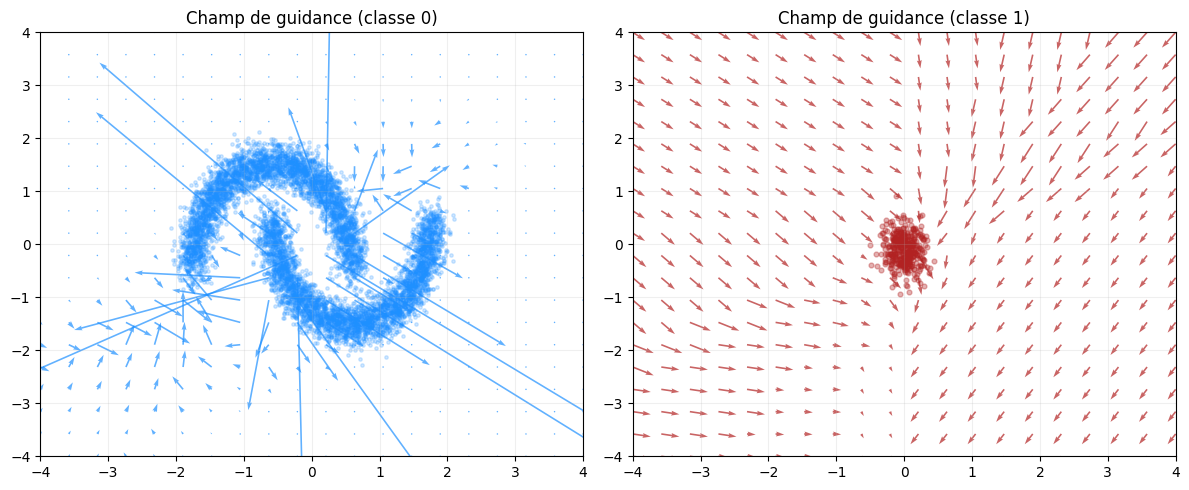

In [21]:
# --- 3.8.3.1 Flow du gradient de guidance J_t ---
print("\n--- Analyse du gradient J_t (flow) ---")

def compute_guidance_J(x, y, classifier, G_cache):
    classifier.eval()
    crit = nn.CrossEntropyLoss()

    x_in = x.detach().clone()
    x_in.requires_grad = True
    out = classifier(x_in)
    loss = crit(out, y)

    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, allow_unused=True)
    filtered = [(p, g) for p, g in zip(classifier.parameters(), grads_phi) if g is not None]
    if not filtered:
        raise ValueError("No parameter received gradient!")
    _, grads_phi = zip(*filtered)
    grads_phi = _normalize_grads(grads_phi)

    influence_score = 0
    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
        if name in G_cache:
            influence_score += torch.sum(g_phi * G_cache[name])

    J = torch.autograd.grad(influence_score, x_in)[0]
    return J.detach()

grid = torch.linspace(-4, 4, 20).to(DEVICE)
xx, yy = torch.meshgrid(grid, grid, indexing="ij")
points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

J0 = compute_guidance_J(points, torch.zeros(len(points), dtype=torch.long).to(DEVICE), clf_bal, G_cache_bal)
J1 = compute_guidance_J(points, torch.ones(len(points), dtype=torch.long).to(DEVICE), clf_bal, G_cache_bal)

J0x = J0[:, 0].reshape(xx.shape).cpu()
J0y = J0[:, 1].reshape(xx.shape).cpu()
J1x = J1[:, 0].reshape(xx.shape).cpu()
J1y = J1[:, 1].reshape(xx.shape).cpu()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].quiver(xx.cpu(), yy.cpu(), J0x, J0y, color="dodgerblue", alpha=0.7)
axes[0].scatter(X_train[y_train == 0][:, 0].cpu(), X_train[y_train == 0][:, 1].cpu(), s=6, alpha=0.2, color="dodgerblue")
axes[0].set_title("Champ de guidance (classe 0)")
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].grid(alpha=0.2)

axes[1].quiver(xx.cpu(), yy.cpu(), J1x, J1y, color="firebrick", alpha=0.7)
axes[1].scatter(X_train[y_train == 1][:, 0].cpu(), X_train[y_train == 1][:, 1].cpu(), s=12, alpha=0.35, color="firebrick")
axes[1].set_title("Champ de guidance (classe 1)")
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()


On regarde maintenant l'intensité du gradient de guidance pour chaque classe.

On observe que le champ de guidance n'est pas isotrope : il s'oriente globalement **vers l'intérieur des régions “sûres” pour la classe conditionnée**.


--- Distribution des normes de J_t ---


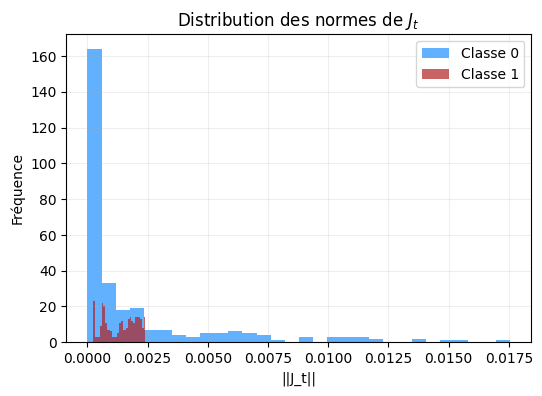

In [22]:
# --- 3.8.3.2 Distribution des normes de J_t ---
print("\n--- Distribution des normes de J_t ---")

def sample_class_points(cls, n=300):
    X_cls = X_train[y_train == cls]
    n = min(n, len(X_cls))
    idx = torch.randperm(len(X_cls))[:n]
    return X_cls[idx]

X0 = sample_class_points(0)
X1 = sample_class_points(1)
J0_train = compute_guidance_J(X0, torch.zeros(len(X0), dtype=torch.long).to(DEVICE), clf_bal, G_cache_bal)
J1_train = compute_guidance_J(X1, torch.ones(len(X1), dtype=torch.long).to(DEVICE), clf_bal, G_cache_bal)

j0_norm = J0_train.norm(dim=1).cpu().numpy()
j1_norm = J1_train.norm(dim=1).cpu().numpy()

plt.figure(figsize=(6, 4))
plt.hist(j0_norm, bins=30, alpha=0.7, label="Classe 0", color="dodgerblue")
plt.hist(j1_norm, bins=30, alpha=0.7, label="Classe 1", color="firebrick")
plt.title("Distribution des normes de $J_t$")
plt.xlabel("||J_t||")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

Les histogrammes de normes montrent que l'intensité de $J_t$ est systématiquement plus élevée sur les exemples minoritaires, ce qui explique la tendance de TarDiff à sur-optimiser la séparation pour cette classe.

### 3.9 Conclusion sur le toy dataset 

todo : à compléter 
(ne pas oublier de parler du fait que sur un dataset équilibré, l'intérêt de tardiff est moins évident et que sur le déséquilibré, ca performe mieux que si on avait simplement sur-échantillonné la classe minoritaire (déjà montré par ddpm simple))

## 4. Données ECG réelles (PTB Diagnostic)

Le dataset PTB Diagnostic ECG (PTBDB) contient des battements cardiaques normalisés, répartis en deux fichiers : un pour les ECG **normaux** et un pour les ECG **anormaux**. On commence par charger les fichiers CSV et inspecter quelques signaux bruts avant d'appliquer TarDiff.

In [23]:
# --- 4.0 Chargement du dataset PTBDB ---
from pathlib import Path
import pandas as pd

data_dir = Path("..") / "data"
normal_path = data_dir / "ptbdb_normal.csv"
abnormal_path = data_dir / "ptbdb_abnormal.csv"

normal_df = pd.read_csv(normal_path, header=None)
abnormal_df = pd.read_csv(abnormal_path, header=None)

def split_signals(df):
    if df.shape[1] > 1 and df.iloc[:, -1].nunique() == 1:
        return df.iloc[:, :-1].values, df.iloc[:, -1].values
    return df.values, None

normal_x, normal_y = split_signals(normal_df)
abnormal_x, abnormal_y = split_signals(abnormal_df)

print("Normal:", normal_x.shape, "Abnormal:", abnormal_x.shape)

Normal: (4046, 187) Abnormal: (10506, 187)


### 4.1 Exemples de signaux ECG

On trace quelques enregistrements bruts pour se familiariser avec la dynamique et le niveau de bruit du jeu de données.

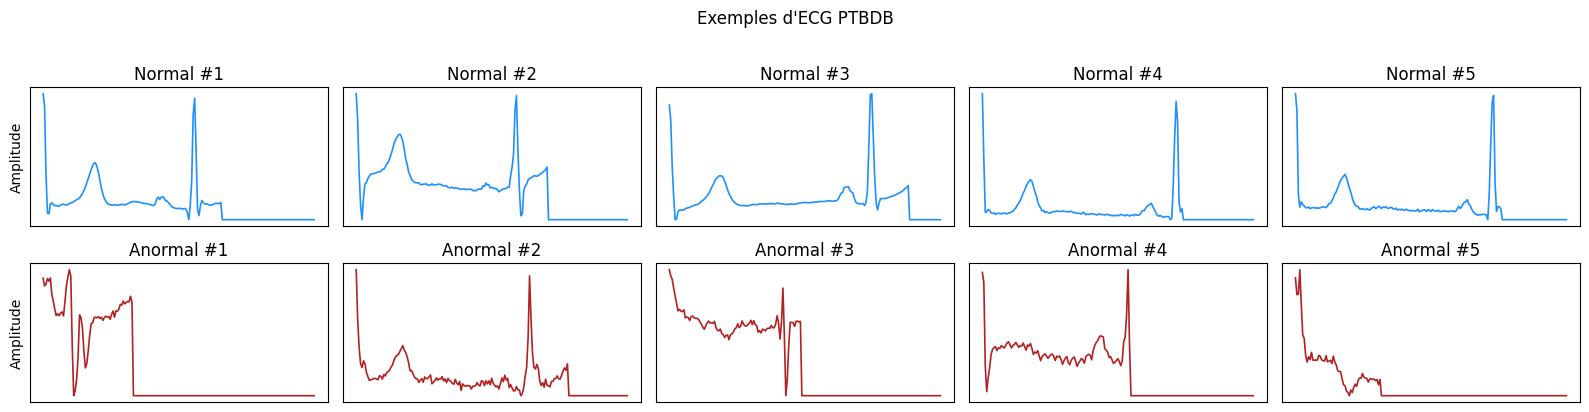

In [24]:
# --- 4.1 Exemples de signaux ECG ---
import matplotlib.pyplot as plt

n_show = 5
fig, axes = plt.subplots(2, n_show, figsize=(3.2 * n_show, 4), sharey=True)

for i in range(n_show):
    axes[0, i].plot(normal_x[i], color="dodgerblue", linewidth=1.2)
    axes[0, i].set_title(f"Normal #{i+1}")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].plot(abnormal_x[i], color="firebrick", linewidth=1.2)
    axes[1, i].set_title(f"Anormal #{i+1}")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

axes[0, 0].set_ylabel("Amplitude")
axes[1, 0].set_ylabel("Amplitude")
plt.suptitle("Exemples d'ECG PTBDB", y=1.02)
plt.tight_layout()
plt.show()

### 4.1 Préparation et sanity check

On crée un scénario de dépistage de maladie rare : **tous les ECG normaux** en classe majoritaire, un **petit sous-ensemble d’anormaux** en classe minoritaire pour l’entraînement, et **le reste des anormaux** en test pour une évaluation robuste.

In [25]:
# --- 4.1 Préparation: split déséquilibré + standardisation ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

rng = np.random.default_rng(42)
torch.manual_seed(42)

n_minor_train = 300
abn_idx = rng.permutation(len(abnormal_x))
abnormal_train = abnormal_x[abn_idx[:n_minor_train]]
abnormal_test = abnormal_x[abn_idx[n_minor_train:]]

normal_train, normal_test = train_test_split(
    normal_x, test_size=0.2, random_state=42, shuffle=True
 )

X_train_ecg = np.vstack([normal_train, abnormal_train])
y_train_ecg = np.hstack([np.zeros(len(normal_train)), np.ones(len(abnormal_train))])
X_test_ecg = np.vstack([normal_test, abnormal_test])
y_test_ecg = np.hstack([np.zeros(len(normal_test)), np.ones(len(abnormal_test))])

mean_ecg = X_train_ecg.mean(axis=0, keepdims=True)
std_ecg = X_train_ecg.std(axis=0, keepdims=True) + 1e-6
X_train_ecg = (X_train_ecg - mean_ecg) / std_ecg
X_test_ecg = (X_test_ecg - mean_ecg) / std_ecg

X_train_ecg_t = torch.tensor(X_train_ecg, dtype=torch.float32).to(DEVICE)
y_train_ecg_t = torch.tensor(y_train_ecg, dtype=torch.long).to(DEVICE)
X_test_ecg_t = torch.tensor(X_test_ecg, dtype=torch.float32).to(DEVICE)
y_test_ecg_t = torch.tensor(y_test_ecg, dtype=torch.long).to(DEVICE)

batch_size_ecg = 128
train_loader_ecg = DataLoader(TensorDataset(X_train_ecg_t, y_train_ecg_t), batch_size=batch_size_ecg, shuffle=True)

n_guide = min(200, len(abnormal_train))
idx_norm = rng.choice(len(normal_train), size=n_guide, replace=False)
idx_abn = rng.choice(len(abnormal_train), size=n_guide, replace=False)
X_guide_ecg = np.vstack([normal_train[idx_norm], abnormal_train[idx_abn]])
y_guide_ecg = np.hstack([np.zeros(n_guide), np.ones(n_guide)])
X_guide_ecg = (X_guide_ecg - mean_ecg) / std_ecg
X_guide_ecg_t = torch.tensor(X_guide_ecg, dtype=torch.float32).to(DEVICE)
y_guide_ecg_t = torch.tensor(y_guide_ecg, dtype=torch.long).to(DEVICE)
guide_loader_ecg = DataLoader(TensorDataset(X_guide_ecg_t, y_guide_ecg_t), batch_size=len(X_guide_ecg_t), shuffle=False)

print("Train:", X_train_ecg_t.shape, "Test:", X_test_ecg_t.shape)
print("Train ratio (normal/anormal):", (y_train_ecg_t == 0).sum().item(), "/", (y_train_ecg_t == 1).sum().item())

Train: torch.Size([3536, 187]) Test: torch.Size([11016, 187])
Train ratio (normal/anormal): 3236 / 300


Sanity check visuel (données standardisées) : les différences entre classes sont subtiles à l'œil nu, contrairement au toy dataset 2D.

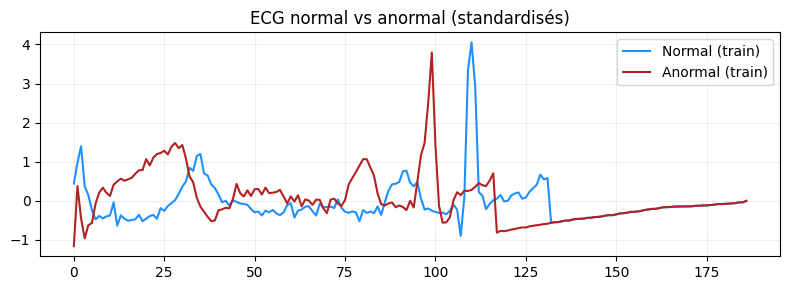

In [26]:
# --- 4.1 Sanity check post-standardisation ---
idx_norm = 0
idx_abn = 0
plt.figure(figsize=(8, 3))
plt.plot(X_train_ecg[y_train_ecg == 0][idx_norm], color="dodgerblue", label="Normal (train)")
plt.plot(X_train_ecg[y_train_ecg == 1][idx_abn], color="firebrick", label="Anormal (train)")
plt.title("ECG normal vs anormal (standardisés)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 4.2 Hypothèse de la "caricature ECG" (analyse qualitative)

Si TarDiff reproduit l'effet observé sur le toy dataset, les ECG anormaux synthétiques devraient être plus "archétypaux" : on s'attend à des pics plus nets dans le signal moyen.

In [27]:
# --- 4.2 Modèles ECG + entraînement (classifieur + diffusion) ---
class ECGClassifier(nn.Module):
    def __init__(self, signal_len=187):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        
        reduced_len = signal_len // 4
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * reduced_len, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        return self.classifier(x)


class ECGDiffusionNet(nn.Module):
    def __init__(self, signal_len=187, t_dim=32):
        super().__init__()
        self.signal_len = signal_len
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim),
        )
        self.net = nn.Sequential(
            nn.Linear(signal_len + t_dim + 1, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, signal_len),
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.float())
        y_emb = y.view(-1, 1).float()
        x_in = torch.cat([x, t_emb, y_emb], dim=1)
        return self.net(x_in)


def eval_classifier_ecg(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
    acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
    auroc = roc_auc_score(y.cpu().numpy(), probs.cpu().numpy())
    auprc = average_precision_score(y.cpu().numpy(), probs.cpu().numpy())
    precision = precision_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    recall = recall_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    f1 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), pos_label=1)
    return dict(acc=acc, auroc=auroc, auprc=auprc, precision=precision, recall=recall, f1=f1)


cfg_ecg = TrainConfig(clf_epochs=15, diff_epochs=25, clf_lr=1e-3, diff_lr=1e-3, timesteps=100)
scheduler_ecg = DDPMScheduler(num_timesteps=cfg_ecg.timesteps, device=DEVICE)
signal_len = X_train_ecg_t.shape[1]

clf_ecg = ECGClassifier(signal_len=signal_len).to(DEVICE)
train_classifier(clf_ecg, train_loader_ecg, cfg_ecg)
metrics_ecg_base = eval_classifier_ecg(clf_ecg, X_test_ecg_t, y_test_ecg_t)
print("Baseline ECG (imbalance):", metrics_ecg_base)

diff_model_ecg = ECGDiffusionNet(signal_len=signal_len).to(DEVICE)
train_diffusion(diff_model_ecg, train_loader_ecg, scheduler_ecg, cfg_ecg)
print("Diffusion ECG trained.")

G_cache_ecg = compute_influence_cache(clf_ecg, guide_loader_ecg)

Baseline ECG (imbalance): {'acc': 0.6762890341321713, 'auroc': 0.9486085406067115, 'auprc': 0.9954226160305363, 'precision': 0.9992481203007518, 'recall': 0.65108759553204, 'f1': 0.7884432842904604}
Diffusion ECG trained.
Diffusion ECG trained.


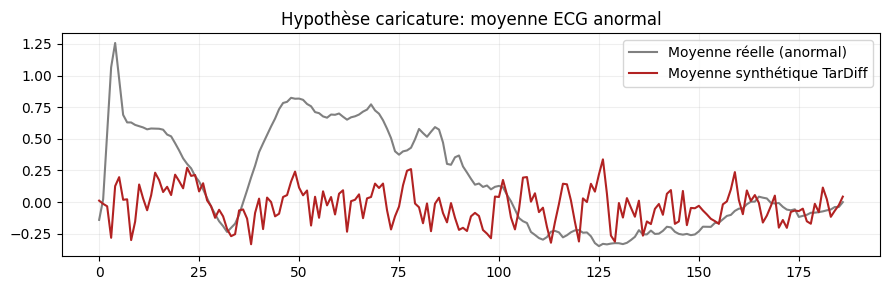

In [28]:
# --- 4.2 Caricature ECG: moyenne réelle vs synthétique ---
def tardiff_sample_ecg(model, scheduler, classifier, G_cache, n_samples=200, target_class=1, w=100.0, signal_len=187):
    model.eval()
    classifier.eval()
    crit_clf = nn.CrossEntropyLoss()

    with torch.no_grad():
        x = torch.randn((n_samples, signal_len)).to(DEVICE)
        y_cond = torch.full((n_samples,), target_class, dtype=torch.long).to(DEVICE)

        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            predicted_noise = model(x, t, y_cond)

            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x_recon = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise)

            J = torch.zeros_like(x)
            if w != 0:
                with torch.enable_grad():
                    x_in = x.detach().clone()
                    x_in.requires_grad = True
                    out_clf = classifier(x_in)
                    loss = crit_clf(out_clf, y_cond)
                    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, allow_unused=True)
                    filtered = [(p, g) for p, g in zip(classifier.parameters(), grads_phi) if g is not None]
                    if not filtered:
                        raise ValueError("No parameter received gradient!")
                    _, grads_phi = zip(*filtered)
                    grads_phi = _normalize_grads(grads_phi)

                    influence_score = 0
                    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
                        if name in G_cache:
                            influence_score += torch.sum(g_phi * G_cache[name])
                    J = torch.autograd.grad(influence_score, x_in)[0]
                J = J.detach()

            sigma_t = torch.sqrt(beta)
            x = x_recon + (w * J) + sigma_t * noise
    return x.detach()

w_ecg = 1000
n_syn_visu = 400
syn_abn_ecg = tardiff_sample_ecg(
    diff_model_ecg, scheduler_ecg, clf_ecg, G_cache_ecg,
    n_samples=n_syn_visu, target_class=1, w=w_ecg, signal_len=signal_len
).cpu().numpy()

real_abn_mean = X_train_ecg[y_train_ecg == 1].mean(axis=0)
syn_abn_mean = syn_abn_ecg.mean(axis=0)

plt.figure(figsize=(9, 3))
plt.plot(real_abn_mean, color="gray", label="Moyenne réelle (anormal)")
plt.plot(syn_abn_mean, color="firebrick", label="Moyenne synthétique TarDiff")
plt.title("Hypothèse caricature: moyenne ECG anormal")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 4.3 TSTR : confirmation de l'utilité (synthetic → real)

On entraîne un classifieur uniquement sur des ECG synthétiques TarDiff, puis on évalue sur le test réel.

In [29]:
# --- 4.3 TSTR ---
n_syn_per_class = 1000
syn_norm_ecg = tardiff_sample_ecg(
    diff_model_ecg, scheduler_ecg, clf_ecg, G_cache_ecg,
    n_samples=n_syn_per_class, target_class=0, w=0.0, signal_len=signal_len
).to(DEVICE)
syn_abn_ecg = tardiff_sample_ecg(
    diff_model_ecg, scheduler_ecg, clf_ecg, G_cache_ecg,
    n_samples=n_syn_per_class, target_class=1, w=w_ecg, signal_len=signal_len
).to(DEVICE)

X_syn_tstr = torch.cat([syn_norm_ecg, syn_abn_ecg])
y_syn_tstr = torch.cat([
    torch.zeros(len(syn_norm_ecg), dtype=torch.long).to(DEVICE),
    torch.ones(len(syn_abn_ecg), dtype=torch.long).to(DEVICE),
])

loader_syn_tstr = DataLoader(TensorDataset(X_syn_tstr, y_syn_tstr), batch_size=128, shuffle=True)
clf_tstr = ECGClassifier(signal_len=signal_len).to(DEVICE)
train_classifier(clf_tstr, loader_syn_tstr, TrainConfig(clf_epochs=15))
metrics_tstr = eval_classifier_ecg(clf_tstr, X_test_ecg_t, y_test_ecg_t)
metrics_tstr

{'acc': 0.8678286129266521,
 'auroc': 0.8418731537730166,
 'auprc': 0.9845256114140823,
 'precision': 0.9572533444816054,
 'recall': 0.8974132863021752,
 'f1': 0.9263679579245474}

### 4.4 TSRTR : augmentation clinique (baseline vs oversampling vs TarDiff)

On compare trois stratégies d'entraînement sur les ECG réels :
- **Baseline** (déséquilibré),
- **Oversampling** classique (duplication + bruit),
- **TarDiff augmentation** (génération d'anormaux synthétiques).

In [30]:
# --- 4.4 TSRTR ---
def oversample_with_noise(X_min, target_n, noise_std=0.05):
    if len(X_min) >= target_n:
        return X_min
    n_extra = target_n - len(X_min)
    idx = np.random.choice(len(X_min), size=n_extra, replace=True)
    noise = np.random.normal(0, noise_std, size=(n_extra, X_min.shape[1]))
    return np.vstack([X_min, X_min[idx] + noise])

X_norm_train = X_train_ecg[y_train_ecg == 0]
X_abn_train = X_train_ecg[y_train_ecg == 1]
target_minor = len(X_norm_train)
n_needed = target_minor - len(X_abn_train)

# Baseline
loader_base = DataLoader(TensorDataset(X_train_ecg_t, y_train_ecg_t), batch_size=128, shuffle=True)
clf_base = ECGClassifier(signal_len=signal_len).to(DEVICE)
train_classifier(clf_base, loader_base, TrainConfig(clf_epochs=15))
metrics_base = eval_classifier_ecg(clf_base, X_test_ecg_t, y_test_ecg_t)

# Oversampling classique
X_abn_over = oversample_with_noise(X_abn_train, target_minor, noise_std=0.05)
y_abn_over = np.ones(len(X_abn_over))
X_over = np.vstack([X_norm_train, X_abn_over])
y_over = np.hstack([np.zeros(len(X_norm_train)), y_abn_over])
X_over_t = torch.tensor(X_over, dtype=torch.float32).to(DEVICE)
y_over_t = torch.tensor(y_over, dtype=torch.long).to(DEVICE)
loader_over = DataLoader(TensorDataset(X_over_t, y_over_t), batch_size=128, shuffle=True)
clf_over = ECGClassifier(signal_len=signal_len).to(DEVICE)
train_classifier(clf_over, loader_over, TrainConfig(clf_epochs=15))
metrics_over = eval_classifier_ecg(clf_over, X_test_ecg_t, y_test_ecg_t)

# TarDiff augmentation
syn_abn_aug = tardiff_sample_ecg(
    diff_model_ecg, scheduler_ecg, clf_ecg, G_cache_ecg,
    n_samples=n_needed, target_class=1, w=w_ecg, signal_len=signal_len
).cpu().numpy()
X_tardiff = np.vstack([X_norm_train, X_abn_train, syn_abn_aug])
y_tardiff = np.hstack([
    np.zeros(len(X_norm_train)),
    np.ones(len(X_abn_train) + len(syn_abn_aug)),
])
X_tardiff_t = torch.tensor(X_tardiff, dtype=torch.float32).to(DEVICE)
y_tardiff_t = torch.tensor(y_tardiff, dtype=torch.long).to(DEVICE)
loader_tardiff = DataLoader(TensorDataset(X_tardiff_t, y_tardiff_t), batch_size=128, shuffle=True)
clf_tardiff = ECGClassifier(signal_len=signal_len).to(DEVICE)
train_classifier(clf_tardiff, loader_tardiff, TrainConfig(clf_epochs=15))
metrics_tardiff = eval_classifier_ecg(clf_tardiff, X_test_ecg_t, y_test_ecg_t)

pd.DataFrame([
    {"setup": "baseline", **metrics_base},
    {"setup": "oversampling", **metrics_over},
    {"setup": "tardiff", **metrics_tardiff},
])

,setup,acc,auroc,auprc,precision,recall,f1
0,baseline,0.693991,0.944326,0.994664,0.998250,0.670880,0.802461
1,oversampling,0.747367,0.962197,0.996341,0.999193,0.727905,0.842243
2,tardiff,0.754630,0.959497,0.995903,0.998406,0.736332,0.847572
